# AUTOENCODER NETWORK

# M. FEUILLET 2021

## Setting up some cleaning functions and the GPU usage

In [1]:
from keras import backend as K
K.clear_session()
try:
    from numba import cuda
    cuda.select_device(0)
    cuda.close()
    import gc
    gc.enable()
except:
    print("An exception occurred, probably from numba of gc. Make sure you have those installed, or pass!")
    

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

#We limit GPU usage 


physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_per_process_gpu_memory_fraction=0.85
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass 

Found GPU at: /device:GPU:0


# Define SSIM loss function 

In [5]:
# Loss function
def ssim_loss(y_true, y_pred):
  return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))

## Define FLIP Loss

In [4]:
#########################################################################
# Copyright (c) 2020, NVIDIA CORPORATION. All rights reserved.
#
# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions
# are met:
#  * Redistributions of source code must retain the above copyright
#    notice, this list of conditions and the following disclaimer.
#  * Redistributions in binary form must reproduce the above copyright
#    notice, this list of conditions and the following disclaimer in the
#    documentation and/or other materials provided with the distribution.
#  * Neither the name of NVIDIA CORPORATION nor the names of its
#    contributors may be used to endorse or promote products derived
#    from this software without specific prior written permission.
#
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS ``AS IS'' AND ANY
# EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR
# PURPOSE ARE DISCLAIMED.  IN NO EVENT SHALL THE COPYRIGHT OWNER OR
# CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL,
# EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO,
# PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR
# PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY
# OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
# (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
#########################################################################

# FLIP: A Difference Evaluator for Alternating Images
# High Performance Graphics, 2020.
# by Pontus Andersson, Jim Nilsson, Tomas Akenine-Moller, Magnus Oskarsson, Kalle Astrom, and Mark D. Fairchild
#
# Pointer to our paper: https://research.nvidia.com/publication/2020-07_FLIP
# code by Pontus Andersson, Jim Nilsson, and Tomas Akenine-Moller

from flip import compute_flip
from utils import *

def flip_loss(true,pred):
	# Set viewing conditions
	monitor_distance = 0.7
	monitor_width = 0.7
	monitor_resolution_x = 128*128
	
	# Compute number of pixels per degree of visual angle
	pixels_per_degree = monitor_distance * (monitor_resolution_x / monitor_width) * (np.pi / 180)
	
	# Load sRGB images
	reference = HWCtoCHW(true)
	test = HWCtoCHW(pred)

	# Compute FLIP map
	deltaE = compute_flip(reference, test, pixels_per_degree)

	# Save error map
	index_map = np.floor(255.0 * deltaE.squeeze(0))

	use_color_map =False # change if want the image
	if use_color_map:
		result = CHWtoHWC(index2color(index_map, get_magma_map()))
	else:
		result = index_map / 255.0
	return(result)


ModuleNotFoundError: No module named 'flip'

## Load images from files. Choose number by using number argument

In [5]:
import cv2
import glob
#from google.colab.patches import cv2_imshow



def cargar_imagenes(source=1,number=10):
    y=0
    x=0
    h=128
    w=128
    if source==1:
        numberphotos= number
        globe=glob.glob("../images/train1/*.png") + glob.glob('../images/train1/*.jpg')+ glob.glob('../images/train1/*.jpeg')
        globee=glob.glob("../images/pred1/*.png") + glob.glob('../images/pred1/*.jpg')+ glob.glob('../images/pred1/*.jpeg')
    elif source==2:
        numberphotos= number
        globe=glob.glob("../images/train2/*.png") + glob.glob('../images/train2/*.jpg')+ glob.glob('../images/train2/*.jpeg')
        globee=glob.glob("../images/pred2/*.png") + glob.glob('../images/pred2/*.jpg')+ glob.glob('../images/pred2/*.jpeg')
    else:
        numberphotos= number
        globe=glob.glob("../images/train3/*.png") + glob.glob('../images/train3/*.jpg')+ glob.glob('../images/train3/*.jpeg')
        globee=glob.glob("../images/pred3/*.png") + glob.glob('../images/pred3/*.jpg')+ glob.glob('../images/pred3/*.jpeg')
        
    
    Xtrain=np.zeros((numberphotos,h,w,3))
    Ytrain=np.zeros((numberphotos,h,w,3))
    i=0 # counter
    
    for file in globe:
      if i<numberphotos:
        img=cv2.imread(file)
        #Crop
        if img.shape[0]>=256 or img.shape[1]>=256:
            center=np.array(img.shape)//2
            img=img[center[0]-128:center[0]+129,center[1]-128:center[1]+129]
        Xtrain[i] = cv2.resize(img,(h,w))
        Xtrain[i] = Xtrain[i].astype('float32')/255
        i+=1
        if i%1000==0:
            print(str(i)+"loaded")
            
            
    i=0 # counter
    for file in globee:
      if i<numberphotos:
        img=cv2.imread(file)
        if img.shape[0]>=256 or img.shape[1]>=256:
            center=np.array(img.shape)//2
            img=img[center[0]-128:center[0]+129,center[1]-128:center[1]+129]
        Ytrain[i] = cv2.resize(img,(h,w))
        Ytrain[i] = Ytrain[i].astype('float32')/255
        i+=1
        if i%1000==0:
            print(str(numberphotos+i)+"loaded")
    

    print("data downloaded")
    return Xtrain,Ytrain



1000loaded
2000loaded
3000loaded
4000loaded
5000loaded
6000loaded
7000loaded
8400loaded
9400loaded
10400loaded
11400loaded
12400loaded
13400loaded
14400loaded
data downloaded
1000loaded
2000loaded
3000loaded
4361loaded
5361loaded
6361loaded
data downloaded
1000loaded
2000loaded
3000loaded
4000loaded
5000loaded
6000loaded
7000loaded
8000loaded
9706loaded
10706loaded
11706loaded
12706loaded
13706loaded
14706loaded
15706loaded
16706loaded
data downloaded


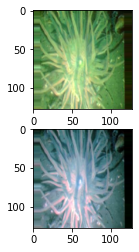

In [6]:
from sklearn.model_selection import train_test_split
X,Y=cargar_imagenes(1)


XX,YY=cargar_imagenes(2)

XXX,YYY=cargar_imagenes(3)


# See if loading worked.
plt.subplot(2,1,1)
plt.imshow(X[1])
plt.subplot(2,1,2)
plt.imshow(Y[1] )
plt.show()

## Definition of model

In [2]:
import keras
from keras.layers import MaxPooling2D,  BatchNormalization, Conv2D,UpSampling2D,Conv2DTranspose,Dropout,Concatenate
from keras.models import Sequential,Model,Input
from keras.optimizers import Adam
from keras.activations import relu

def activ(x):
    #define bounded relu
    return(relu(x,max_value=1))


def autoencoder():
    
    
    input=Input(shape=(128,128,3))

    #small shapes autoencoder
    conv11=Conv2D(64*3, (1, 1), activation=activ,padding='same')(input)
    norm11=BatchNormalization()(conv11)
    samp11=MaxPooling2D((4,4), padding='same')(norm11)
    drop1=Dropout(.15)(samp11)
    conv21=Conv2D(64, (1,1), activation=activ,padding='same')(drop1)
    samp21=MaxPooling2D((4,4), padding='same')(conv21)
    up21=UpSampling2D((4, 4))(samp21)
    conv31=Conv2DTranspose(64, (1,1), activation=activ,padding='same')(up21)
    norm21=BatchNormalization()(conv31)
    up11=UpSampling2D((4, 4))(norm21)
    conv41=Conv2DTranspose(64*3, (1,1), activation=activ,padding='same')(up11)
    conv51=Conv2D(3, (3, 3), activation=activ,padding='same')(conv41)
    
    # Normal autoencoder
    conv1=Conv2D(64*3, (3, 3), activation=activ,padding='same')(conv51)
    norm1=BatchNormalization()(conv1)
    samp1=MaxPooling2D((4,4), padding='same')(norm1)
    drop=Dropout(.15)(samp1)
    conv2=Conv2D(64, (3,3), activation=activ,padding='same')(drop)
    samp2=MaxPooling2D((4,4), padding='same')(conv2)
    up2=UpSampling2D((4, 4))(samp2)
    conv3=Conv2DTranspose(64, (3,3), activation=activ,padding='same')(up2)
    norm2=BatchNormalization()(conv3)
    up1=UpSampling2D((4, 4))(norm2)
    conv4=Conv2DTranspose(64*3, (3,3), activation=activ,padding='same')(up1)
    conv5=Conv2D(3, (3, 3), activation=activ,padding='same')(conv4)
    
    # Big shapes autoencoder
    conv19=Conv2D(64*3, (5, 5), activation=activ,padding='same')(conv51)
    norm19=BatchNormalization()(conv19)
    samp19=MaxPooling2D((4,4), padding='same')(norm19)
    drop9=Dropout(.15)(samp19)
    conv29=Conv2D(64, (5,5), activation=activ,padding='same')(drop9)
    samp29=MaxPooling2D((4,4), padding='same')(conv29)
    up29=UpSampling2D((4, 4))(samp2)
    conv39=Conv2DTranspose(64, (3,3), activation=activ,padding='same')(up2)
    norm29=BatchNormalization()(conv3)
    up19=UpSampling2D((4, 4))(norm2)
    conv49=Conv2DTranspose(64*3, (3,3), activation=activ,padding='same')(up1)
    conv59=Conv2D(3, (3, 3), activation=activ,padding='same')(conv4)

    
    #Vertical convolutions
    conv12=Conv2D(64*3, (1,3), activation=activ,padding='same')(input)
    norm12=BatchNormalization()(conv12)
    samp12=MaxPooling2D((4,4), padding='same')(norm12)
    drop2=Dropout(.15)(samp12)
    conv22=Conv2D(64, (1,3), activation=activ,padding='same')(drop2)
    samp22=MaxPooling2D((4,4), padding='same')(conv22)
    up22=UpSampling2D((4, 4))(samp22)
    conv32=Conv2DTranspose(64, (3,1), activation=activ,padding='same')(up22)
    norm22=BatchNormalization()(conv32)
    up12=UpSampling2D((4, 4))(norm22)
    conv42=Conv2DTranspose(64*3, (3,1), activation=activ,padding='same')(up12)
    conv52=Conv2D(3, (3, 3), activation=activ,padding='same')(conv42)
    
    #horizontal convolutions
    conv13=Conv2D(64*3, (3,1), activation=activ,padding='same')(input)
    norm13=BatchNormalization()(conv13)
    samp13=MaxPooling2D((4,4), padding='same')(norm13)
    drop3=Dropout(.15)(samp13)
    conv23=Conv2D(64, (3,1), activation=activ,padding='same')(drop3)
    samp23=MaxPooling2D((4,4), padding='same')(conv23)
    up23=UpSampling2D((4, 4))(samp23)
    conv33=Conv2DTranspose(64, (1,3), activation=activ,padding='same')(up23)
    norm23=BatchNormalization()(conv33)
    up13=UpSampling2D((4, 4))(norm23)
    conv43=Conv2DTranspose(64*3, (1,3), activation=activ,padding='same')(up13)
    conv53=Conv2D(3, (3, 3), activation=activ,padding='same')(conv43)
    
    
    conc=Concatenate(axis=3)([input,conv5,conv51,conv52,conv53,conv59])

    conv5=Conv2D(3, (3, 3), activation=activ,padding='same')(conc)
    opt = Adam(lr=5e-5)
    total=Model(inputs=input,outputs=conv5)
    total.compile(loss='mean_squared_error', optimizer= opt , metrics = ["accuracy",ssim_loss])
    return(total)




## Uncomment this if you want to use CPU and do not launch next, else keep as it is

In [ ]:
"""with tf.device("/CPU:0"):
    model_gen = autoencoder()

    model_gen.summary()"""


In [6]:
model_gen = autoencoder()

model_gen.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 128, 128, 192 768         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 128, 128, 192 768         conv2d_16[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, 32, 32, 192)  0           batch_normalization_10[0][0]     
____________________________________________________________________________________________

## Load weights

In [7]:
model_gen.load_weights('./weights1802')

## Visualization of results

In [8]:
from time import time

def visualize(img,orig,model,i):
    """Draws original and decoded images"""
    t0=time()
    code = model.predict(np.array([img]))

    fig=plt.figure()
    plt.subplot(1,4,1)
    plt.title("Original")
    #img=cv2.cvtColor(img, cv2.COLOR_HSV2BGR) 
    #img=cv2.cvtColor(np.float32(img)*255,cv2.COLOR_LUV2BGR)
    b,g,r=cv2.split(img)
    img=cv2.merge([r,g,b])
    plt.imshow(img)
    plt.subplot(1,4,2)
    plt.title("Ideal Solution")
    #img=cv2.cvtColor(img, cv2.COLOR_HSV2BGR) 
    #img=cv2.cvtColor(np.float32(img)*255,cv2.COLOR_LUV2BGR)
    b,g,r=cv2.split(orig)
    orig=cv2.merge([r,g,b])
    plt.imshow(orig)
    plt.subplot(1,4,3)
    plt.title("Reconstructed")
    #res=cv2.cvtColor(code[0], cv2.COLOR_HSV2BGR)
    #res=cv2.cvtColor(np.float32(code[0])*255, cv2.COLOR_LUV2BGR)
    res=code[0]
    b,g,r=cv2.split(res)
    res=cv2.merge([r,g,b])
    plt.imshow(res)
    plt.subplot(1,4,4)
    plt.title("FLIP difference")
    plt.imshow(flip_loss(orig,res))
    plt.show()
    fig.savefig(str(i)+".png")
    print("time:"+str(time()-t0))

    
for i in range(len(X)):
    img = X[i]
    orig = Y[i]
    visualize(img,orig,model_gen,i)
for i in range(len(XX)):
    img = XX[i]
    orig = YY[i]
    visualize(img,orig,model_gen,i)
for i in range(len(XXX)):
    img = XXX[i]
    orig = YYY[i]
    visualize(img,orig,model_gen,i)
    

NameError: name 'X' is not defined